In [89]:
import numpy as np
import xarray as xr
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import re

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
from bopak.reprocess import albedo_db, iceage_db, onset_db, sic, onset, iceage, albedo, set_BOEASE2, ptproj, loc_ease2
from bopak.reprocess.test_year import test_year


### Testing albedo accordion
* Choose a year to check
* load data
* Choose a lat/lon pair to plot accordion
  * add xlim to zoom in on dates
* choose two pairs to compare accordion

In [476]:
tyr = 2006
albroot = Path('/data/BO/EASE2/albedo')
ONSET_ROOT = Path('/data/BO/EASE2/onset/')
IA_ROOT = Path('/data/BO/EASE2/ICEAGE/V4')
test0 = test_year(tyr, alb_root=albroot, onset_root=ONSET_ROOT, ia_root=IA_ROOT)
test0.load_data()

/data/BO/EASE2/onset/2006731smeltfreeze.nc /data/BO/EASE2/ICEAGE/V4/iceage_nh_12.5km_20060101_20061231_v4.1.nc /data/BO/EASE2/albedo/albedo_BO_2006_V0.02.nc


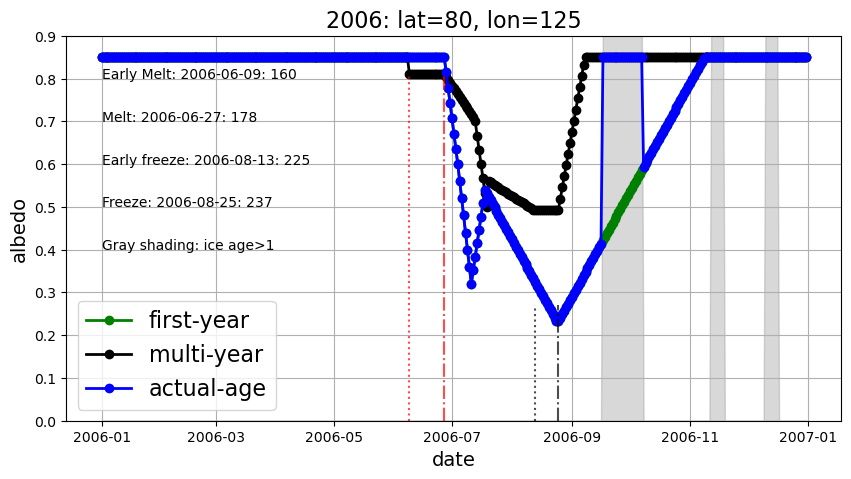

In [488]:
lon = 125
lat = 80
fig,ax = test0.plot_accordion(*(lat,lon),
                              #xlim=('2006-07-12','2006-09-15'),
                              marker='o',ms=6,
                              )

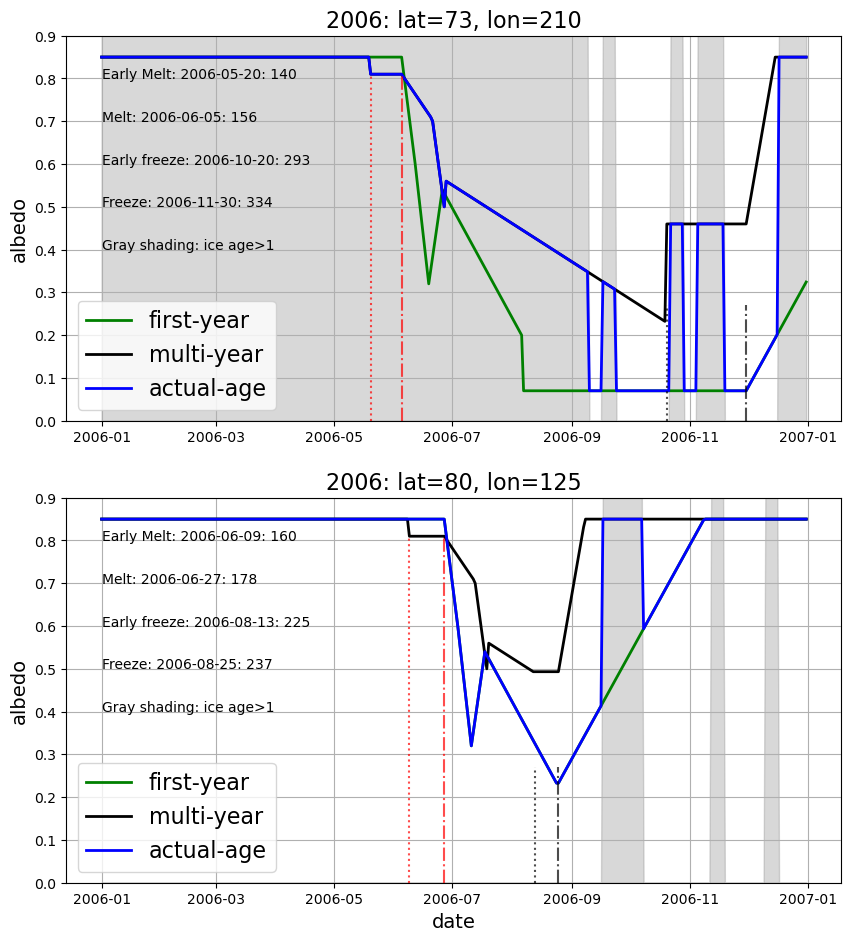

In [495]:
fig,ax = test0.compare_accordion((73,210),(80,125),
                              #xlim=('2006-05-12','2006-12-15'),
                              #marker='o',ms=6,
                                 )

### Plot onset dates on EASE2 grid. 

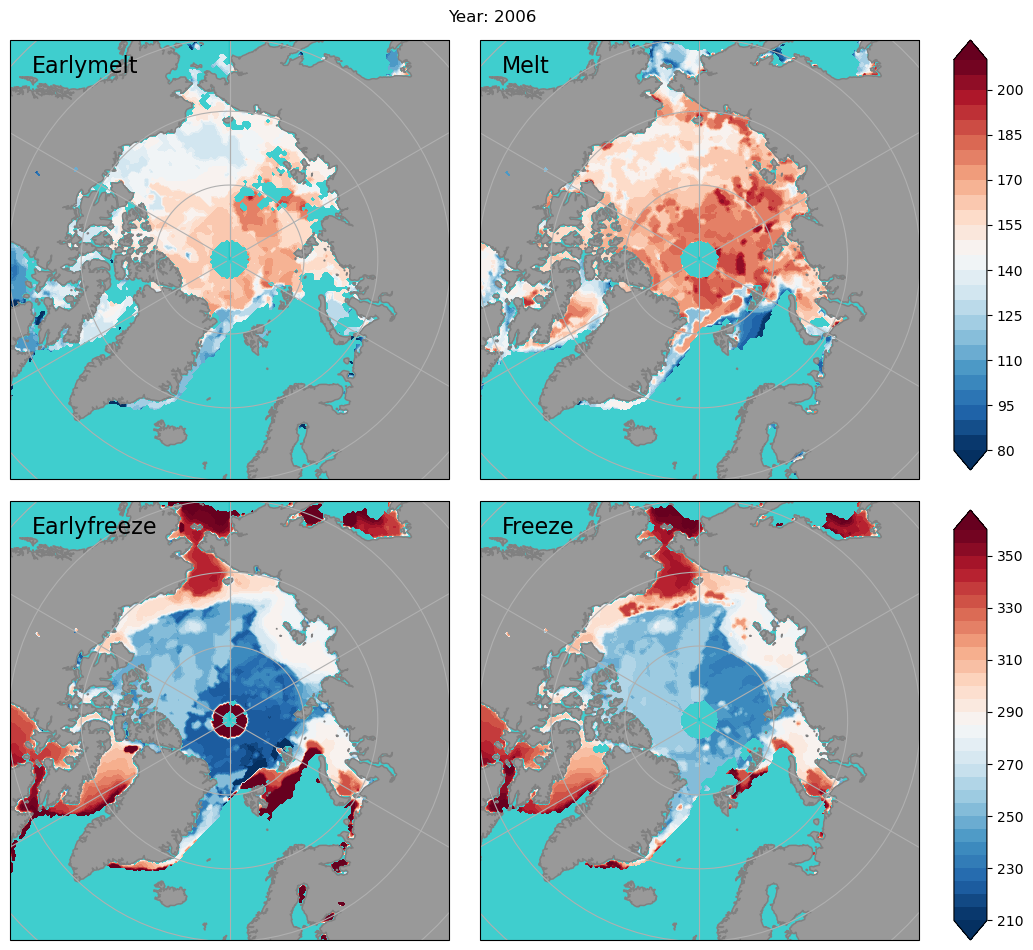

In [496]:
fig,axs = test0.plot_onset()

### Plot original onset data
* read data
* set up grid and color levels
* plot side by side
* plot all original dates

In [497]:

ONSETNC_ORG = Path('/data/BO/MeltFreezeOnset_NetCDF/')
onset_df = onset_db(ONSETNC_ORG)
fn_onset = onset_df[onset_df.time.dt.year==tyr].iloc[0].fn

with xr.open_dataset(fn_onset) as ds_onset:
    ds_onset.load()

In [498]:
# --- setup map projection and color levels
pcproj = ccrs.PlateCarree()
mds, boprj = set_BOEASE2()
XLIM = mds.XLIM
YLIM = mds.YLIM

xo,yo = ptproj(pcproj,boprj,ds_onset.Longitude.values, ds_onset.Latitude.values)
xx,yy = np.meshgrid(mds.X.values, mds.Y.values)

mlvl = levels=np.linspace(80,210,27)
flvl = levels=np.linspace(210,360,31)

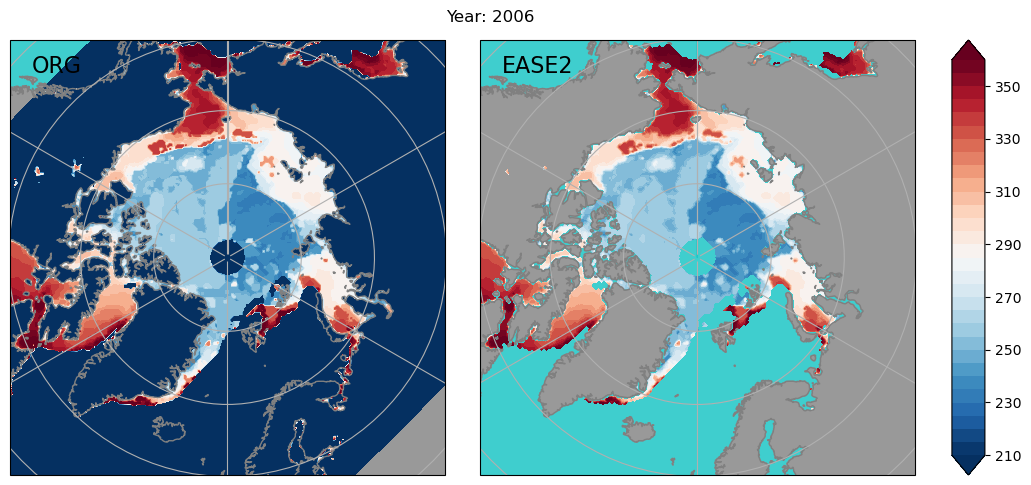

In [500]:
rdat = test0.onset
vn = 'Freeze'
lvls = flvl #mlvl
ftsz=16
from cartopy.feature import OCEAN 
from cartopy.feature import LAND
vns = ['Earlymelt','Melt','Earlyfreeze','Freeze']
chdls = []
fig, axs = plt.subplots(1,2,figsize=(11,5),subplot_kw=dict(projection=boprj))
ax = axs[0]
ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
ax.coastlines(color='.5')
ax.gridlines()
chdl = ax.contourf(xo,yo,ds_onset[vn].values,cmap='RdBu_r',levels=lvls,extend='both')
ax.add_feature(OCEAN,color='c',alpha=.5)
ax.add_feature(LAND,color='.6')
ax.annotate('ORG',(-XLIM*.9,YLIM*.85),fontsize=ftsz)
ax = axs[1]
ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
ax.coastlines(color='.5')
ax.gridlines()
chdl = ax.contourf(xx,yy,rdat[vn].values,cmap='RdBu_r',levels=lvls,extend='both')
ax.annotate('EASE2',(-XLIM*.9,YLIM*.85),fontsize=ftsz)
ax.add_feature(OCEAN,color='c',alpha=.5)
ax.add_feature(LAND,color='.6')
fig.subplots_adjust(wspace=0.01,hspace=.05,top=.92,bottom=.05,left=.05,right=.90)
fig.suptitle(f'Year: {tyr}')
cax = fig.add_axes([.92,.05,.03,.87])
fig.colorbar(chdl,ax=ax,cax=cax)

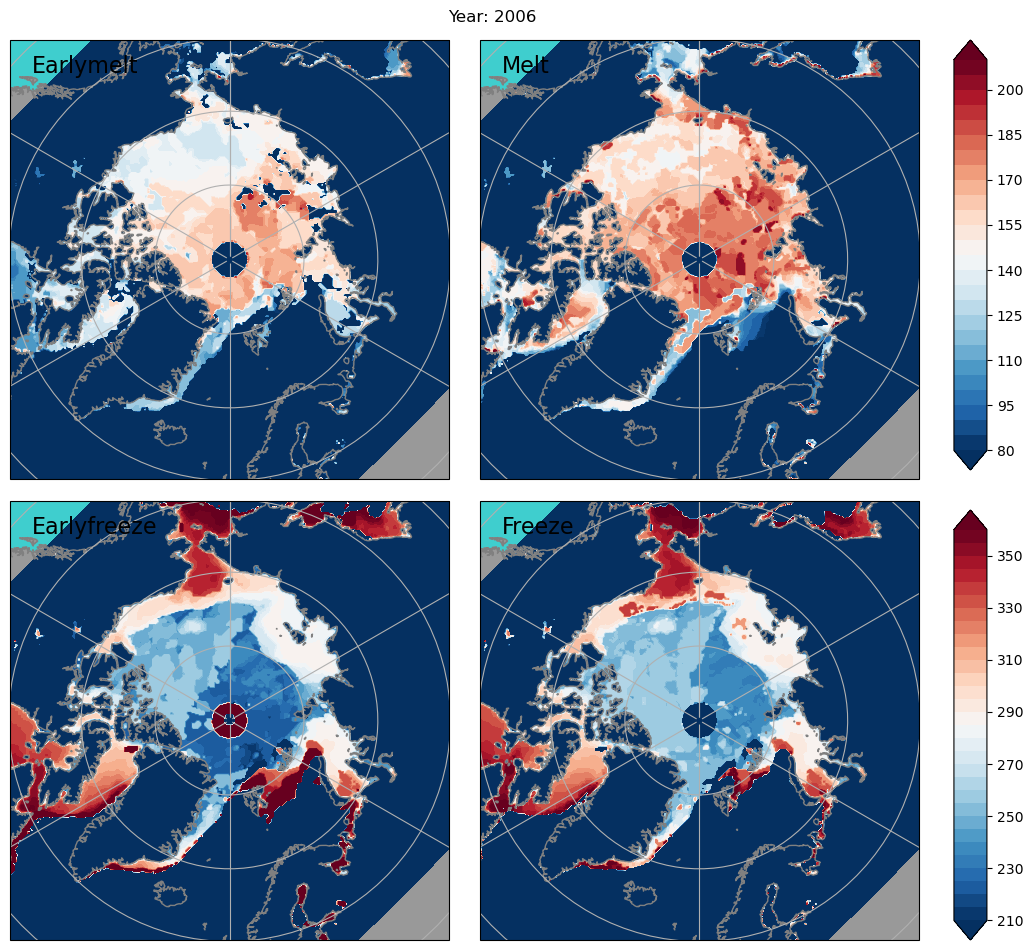

In [470]:
ftsz=16
from cartopy.feature import OCEAN 
from cartopy.feature import LAND
vns = ['Earlymelt','Melt','Earlyfreeze','Freeze']
chdls = []
fig, axs = plt.subplots(2,2,figsize=(11,10),subplot_kw=dict(projection=boprj))
for iplt in range(4):
    irow = iplt//2
    icol = iplt%2
    vn = vns[iplt]
    ax = axs[irow,icol]

    ax = axs[irow,icol]
    ax.set_extent([-XLIM,XLIM,-YLIM,YLIM],crs=boprj)
    ax.coastlines(color='.5')
    ax.gridlines()
    lvls = mlvl if iplt<2 else flvl
    chdl = ax.contourf(xo,yo,ds_onset[vn].values,cmap='RdBu_r',levels=lvls,extend='both')
    chdls.append(chdl)
    ax.add_feature(OCEAN,color='c',alpha=.5)
    ax.add_feature(LAND,color='.6')
    ax.annotate(vn,(-XLIM*.9,YLIM*.85),fontsize=ftsz)
fig.subplots_adjust(wspace=0.01,hspace=.05,top=.95,bottom=.05,left=.05,right=.90)
fig.suptitle(f'Year: {tyr}')
cax = fig.add_axes([.92,.52,.03,.43])
fig.colorbar(chdls[0],ax=ax,cax=cax)
cax = fig.add_axes([.92,.05,.03,.43])
fig.colorbar(chdls[-1],ax=ax,cax=cax)
